# Isomap

In [1]:
import numpy as np
import torch
from torch.autograd import Variable

import sklearn.datasets
from scipy.spatial.distance import euclidean
import matplotlib.pyplot as plt
from copy import deepcopy

# Get and plot swiss roll dataset

In [2]:
X, t = sklearn.datasets.make_swiss_roll(n_samples=1000)

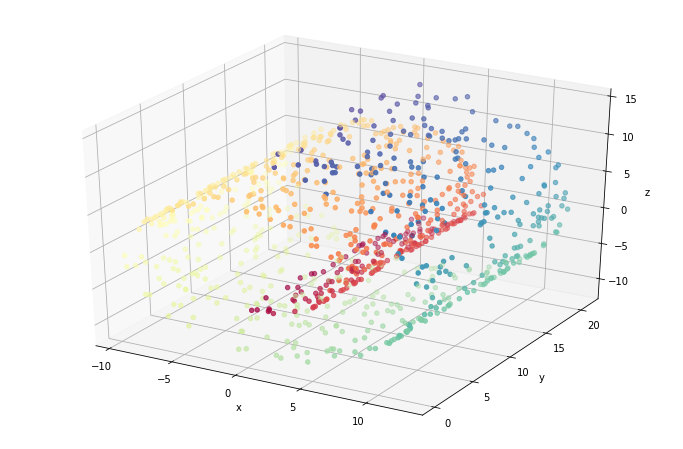

In [3]:
fig = plt.figure(figsize=(12,8))
ax = plt.axes(projection="3d")
ax.scatter(X[:,0], X[:,1], X[:,2], c=t, cmap=plt.cm.Spectral);
ax.set_xlabel('x'); ax.set_ylabel('y'); ax.set_zlabel('z');
plt.show()

# Step 1: K Nearest Neighbours and Distance Matrix

In [4]:
def distance_matrix(X, k=6):
    """
    Computes the (local) distance matrix using Euclidean distance
    """
    # Compute full distance matrix
    distances = np.array([[euclidean(p1, p2) for p2 in X] for p1 in X])

    # Keep only the nearest neighbors, others set to infinity (= unreachable)
    n = X.shape[0]
    unreachables = np.argsort(distances, axis=1)[:,k+1:]
    distances[np.arange(n)[:,None],unreachables] = np.inf
    return distances

# Step 2: Shortest paths

In [5]:
def floyd_warshall(dist):
    """
    Computes the shortest path (distance) for each pair of points
    """
    n = dist.shape[0]
    # Make graph symmetric
    for i in range(n):
        for j in range(i+1, n):
            if dist[i,j] > dist[j,i]:
                dist[i,j] = dist[j,i]
            else:
                dist[j,i] = dist[i,j]
    # Perform Floyd Warshall
    for k in range(n):
        for i in range(n):
            if dist[i,k] == np.inf:
                continue
            for j in range(n):
                if dist[i,j] > dist[i,k] + dist[k,j]:
                    dist[i,j] = dist[i,k] + dist[k,j]
    return dist

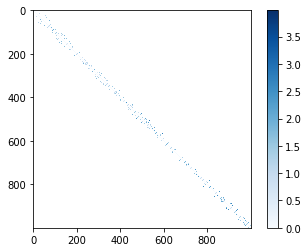

In [6]:
XX = X[np.argsort(t),:] # Sorting based on t to visualise distances
dist = distance_matrix(XX)
plt.imshow(dist, zorder=2, cmap='Blues', interpolation='nearest')
plt.colorbar();

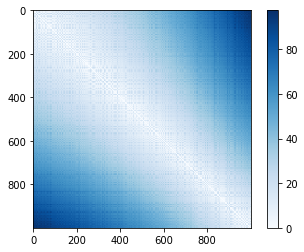

In [7]:
dist = floyd_warshall(dist)
plt.imshow(dist, zorder=2, cmap='Blues', interpolation='nearest')
plt.colorbar();

# Step 3: Multidimensional Scaling (MDS)

## Classical MDS
$$Y = E_p \Lambda_p^{1/2}$$
where $E_p$ is a matrix of Eigen vectors and $\Lambda_p$ is a diagonal matrix of Eigen values

In [8]:
def center(K):
    """ Center the distance matrix """
    n_samples = K.shape[0]

    # Mean for each row/column
    meanrows = np.sum(K, axis=0) / n_samples
    meancols = (np.sum(K, axis=1)/n_samples)[:, np.newaxis]

    # Mean across all rows (entire matrix)
    meanall = meanrows.sum() / n_samples

    D = deepcopy(K)
    D -= meanrows
    D -= meancols
    D += meanall
    return D

def mds(dist, p=2):
    """
    Classical multidimensional scaling: Eigen solution based on distance matrix
    """
    # Center distance matrix
    D = center(dist)
    
    # Solve for (eigenvalue, eigenvector) tuples
    eig_val, eig_vec = np.linalg.eig(D)
    eig_val = np.abs(eig_val)
    largest = np.argsort(-1*eig_val)[:p] # indices of p largest eigenvalues

    # Projection to new subspace
    return eig_vec[:,largest] @ np.sqrt(np.diag(eig_val[largest]))

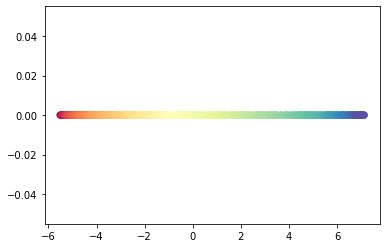

In [9]:
y_cmds1 = mds(dist, 1)
plt.scatter(y_cmds1, np.zeros(len(y_cmds1)), c=t[np.argsort(t)], cmap=plt.cm.Spectral);
plt.show();

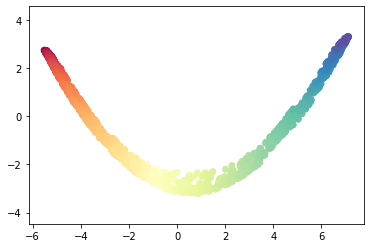

In [10]:
y_cmds2 = mds(dist)
plt.scatter(y_cmds2[:,0], y_cmds2[:,1], c=t[np.argsort(t)], cmap=plt.cm.Spectral);
plt.axis('equal');
plt.show();

## Metric MDS
Using iterative optimization to minimize the stress function:
$$STRESS= \left(\frac{\sum_{i>j}(D_{ij} - \delta_{ij})^2}{\sum_{i>j}D_{ij}^2}\right)^{1/2}$$
where $D$ is the distance matrix in the original space and $\delta$ is the distance matrix in the lower dimension space.

In [11]:
def mmds(dist, init_y=None, p=2, epochs=50):
    """
    Performs metric multidimensional scaling from n to p using gradient descent
    """
    n = dist.shape[0]
    dist = torch.tensor(dist)
    if init_y is None:
        init_y = torch.randn(n, p)
    y = Variable(init_y, requires_grad=True)

    def distance(a, b):
        """ Torch version of Euclidean distance """
        return torch.sqrt(torch.sum((a-b)**2))
    
    def stress(dist, y):
        sres = 0
        for i in range(n):
            for j in range(i+1,n):
                sres += (dist[i,j]-distance(y[i],y[j]))**2
        sdsq = torch.sum(dist**2)/2
        return torch.sqrt(sres/sdsq)
    
    losses = []
    opt = torch.optim.Adam([y], lr=5)
    for i in range(epochs):
        loss = stress(dist, y)
        opt.zero_grad()
        loss.backward()
        opt.step()
        losses.append(loss.detach().numpy())
        if i % 10 == 0:
            print(f"loss={loss}")
    plt.plot(losses)

    return y

loss=0.838046366069032
loss=0.16517981979013466
loss=0.0995512547037581
loss=0.07690479926955748
loss=0.05466038970481591


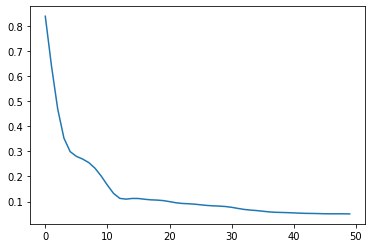

In [12]:
y_mmds = mmds(dist, init_y=torch.tensor(y_cmds2)) # Start from classical mds solution

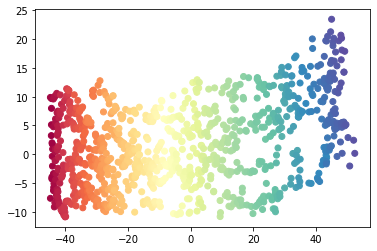

In [13]:
y_mmds = y_mmds.detach().numpy()
plt.scatter(y_mmds[:,0], y_mmds[:,1], c=t[np.argsort(t)], cmap=plt.cm.Spectral);
plt.show();

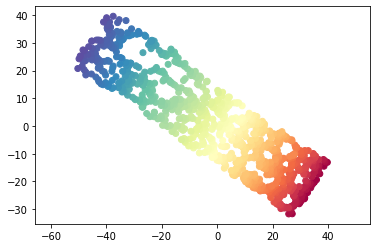

In [14]:
from sklearn.manifold import MDS
model = MDS(n_components=2, dissimilarity='precomputed')
out = model.fit_transform(dist)
plt.scatter(out[:, 0], out[:, 1], c=t[np.argsort(t)], cmap=plt.cm.Spectral)
plt.axis('equal');

# Model validation
Plot distances in original space and the projected space

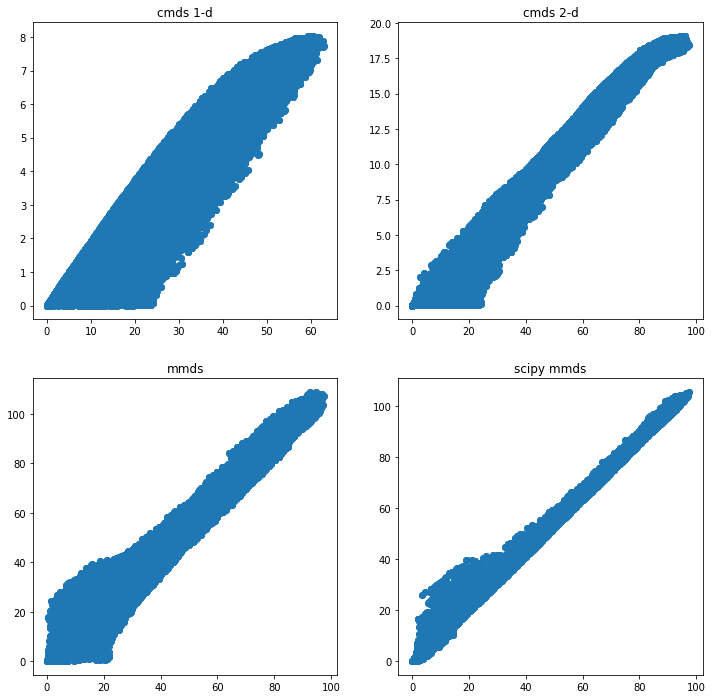

In [15]:
fig, axs = plt.subplots(2,2,figsize=(12,12))
axs[0,0].scatter(dist, floyd_warshall(distance_matrix(y_cmds1)))
axs[0,0].set_title('cmds 1-d')
axs[0,1].scatter(dist, floyd_warshall(distance_matrix(y_cmds2)))
axs[0,1].set_title('cmds 2-d')
axs[1,0].scatter(dist, floyd_warshall(distance_matrix(y_mmds)))
axs[1,0].set_title('mmds')
axs[1,1].scatter(dist, floyd_warshall(distance_matrix(out)))
axs[1,1].set_title('scipy mmds');